## **PROBLEM STATEMENT**

**Autonomous Driving has been recent ingenious application of deeplearning. Many biggies like uber,nvidia,tesla,google are working on this application. A self-driving car has to identify/detect several things like roads, traffic signals, humans/vehicles. Having this the another most important task is to predict the steering angle of the car in accordance with the upcoming road turn. So, the problem statement concludes to, given an image of road ahead we need to predict the steering angle of the car.**

## **DATASET DESCRIPTION**

**A total of 45,405 images have been captured using the front dashboard camera of the car (link can be found in the references section). Due to less computational power i have considered using only the first 10,000 images of which 9,000 images were used for training. 500 for validation, 500 for testing purposes.**

## **EVALUATION METRIC USED**

**- Mean Squared Error (MSE)**

## **BASE-LINE MODELS  CONSIDERED**

**1. As most of the times road will be straighter, what if every predcition angle of steering is 0 degrees for any given image of the road.**

**2. What if every prediction angle of steering for any given image of the road is mean of the steering angles present in the training dataset.**

**3. So as no new thing, the deep learning models we implement should perform better than the above 2 random models**

## **DEEP LEARNING MODELS USED**

**1. CNN layers followed by dense layers with "atan" activation in the output layer.**

**2. Transfer Learning - Using pre-trained weights of RESNET-50 with "atan" activation in the output layer**

**- The motive behing using "atan" activation function is, the range of inverse tan (or atan) is from -90 to +90  which are the extremeties of steering angles for a car moving forward.**

## **MOUNTING THE GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **IMPORTING REQUIRED MODULES**

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras import metrics  
from keras.layers import Flatten
import tensorflow as tf
import sys, os.path
import glob
import matplotlib
import pickle
from tqdm import tqdm
import cv2
import skimage.io as io
import scipy
import keras
from keras.preprocessing import image
from keras.layers import Dropout
from keras.preprocessing.image import load_img
from keras.layers.normalization import BatchNormalization
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50
from skimage.transform import resize
from sklearn.metrics import mean_squared_error
import seaborn as sb

Using TensorFlow backend.


## **READING THE STEERING ANGLES DATA (IMAGE NAME VS STEERING ANGLE)**

In [ ]:
img_vs_ang = pd.read_csv("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data.txt",delimiter=" ",header=None,names=["Image_Name","Angle_in_Degrees"])

In [ ]:
img_vs_ang.tail()

,Image_Name,Angle_in_Degrees
45401,45401.jpg,2.22
45402,45402.jpg,2.22
45403,45403.jpg,2.22
45404,45404.jpg,2.22
45405,45405.jpg,0.00


## **CONVERTING THE STEERING ANGLES IN DEGREES TO RADIANS (TO OBTAIN A LIMITED RANGE OF NUMBERS)**

In [ ]:
pi = (22/7)
for i in range(len(img_vs_ang)):
  img_vs_ang.iloc[i,1] = float(img_vs_ang.iloc[i,1]) * (pi/180)
img_vs_ang.tail()

,Image_Name,Angle_in_Degrees
45401,45401.jpg,0.038762
45402,45402.jpg,0.038762
45403,45403.jpg,0.038762
45404,45404.jpg,0.038762
45405,45405.jpg,0.000000


In [ ]:
img_vs_ang.head()

,Image_Name,Angle_in_Degrees
0,0.jpg,0.0
1,1.jpg,0.0
2,2.jpg,0.0
3,3.jpg,0.0
4,4.jpg,0.0


## **READING THE IMAGES AND ALIGNING THEM WITH CORRESPONDING ANGLES**

In [ ]:
path="/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/5000-9999"
count_images = next(os.walk(path+"/"))[2] # list of names all images in the given path
print("Count of Images::", len(count_images))

Count of Images:: 5000


In [ ]:
def read_images(path,start,end,flag):
  #img_data=pd.DataFrame(columns=["image","radian_angle"],)
  if(flag==0):
    img_data = np.zeros((5000,66,200,3), dtype=np.float)
    img_angles = np.zeros((5000,1))
  else:
    img_data = np.zeros((5406,66,200,3), dtype=np.float)
    img_angles = np.zeros((5406,1))
  row=0
  for i in tqdm(range(start,end),leave=True,position=0):
    img_name = img_vs_ang.iloc[i,0]
    img_angle = img_vs_ang.iloc[i,1]
    im = load_img(path+"/"+img_name)
    conv_img = image.img_to_array(im,data_format="channels_last") 
    #keeping the color-channel at the end in the representation of image vector
    conv_img = resize(conv_img,(66,200,3)) 
    ## resizing image to 66x200 size
    conv_img = conv_img/255 
    # performing the min-max normalization
    #img_data.loc[i] = [conv_img,img_angle]
    img_data[row] = conv_img
    img_angles[row] = img_angle
    row+=1 
  return img_data,img_angles

In [ ]:
data_0to4999,data_0to4999_angles = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/0-4999",0,5000,0)

100%|██████████| 5000/5000 [24:40<00:00,  3.38it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_0to4999.npy",data_0to4999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_0to4999_angles.npy",data_0to4999_angles)'''

In [ ]:
data_5000to9999,data_5000to9999_angles = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/5000-9999",5000,10000,0)

100%|██████████| 5000/5000 [26:56<00:00,  3.09it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_5000to9999.npy",data_5000to9999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_5000to9999_angles.npy",data_5000to9999_angles)'''

In [ ]:
data_10000to14999,data_10000to14999_angles = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/10000-14999",10000,15000,0)

100%|██████████| 5000/5000 [24:34<00:00,  3.39it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_10000to14999.npy",data_10000to14999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_10000to14999_angles.npy",data_10000to14999_angles)'''

In [ ]:
data_15000to19999,data_15000to19999_angles = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/15000-19999",15000,20000,0)

100%|██████████| 5000/5000 [24:51<00:00,  3.35it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_15000to19999.npy",data_15000to19999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_15000to19999_angles.npy",data_15000to19999_angles)'''

In [ ]:
data_20000to24999,data_20000to24999_angles = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/20000-24999",20000,25000,0)

100%|██████████| 5000/5000 [25:52<00:00,  3.22it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_20000to24999.npy",data_20000to24999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_20000to24999_angles.npy",data_20000to24999_angles)'''

In [ ]:
data_25000to29999 = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/25000-29999",25000,30000,0)

100%|██████████| 5000/5000 [58:15<00:00,  1.43it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_25000to29999.npy",data_25000to29999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_25000to29999_angles.npy",data_25000to29999_angles)'''

In [ ]:
data_30000to34999 = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/30000-34999",30000,35000,0)

100%|██████████| 5000/5000 [57:16<00:00,  1.45it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_30000to34999.npy",data_30000to34999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_30000to34999_angles.npy",data_30000to34999_angles)'''

In [ ]:
data_35000to39999 = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/35000-39999",35000,40000,0)

100%|██████████| 5000/5000 [35:59<00:00,  2.32it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_35000to39999.npy",data_35000to39999)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_35000to39999_angles.npy",data_35000to39999_angles)'''

In [ ]:
data_40000to45405 = read_images("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/dataset/40000-45405",40000,45406,1)

100%|██████████| 5406/5406 [40:11<00:00,  2.24it/s]


In [ ]:
'''np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_40000to45405.npy",data_40000to45405)
np.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_40000to45405_angles.npy",data_40000to45405_angles)'''

## **LOADING THE SAVED FILES**

In [2]:
data_0to4999 = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_0to4999.npy")
data_0to4999_angles = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_0to4999_angles.npy")

In [3]:
data_5000to9999 = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_5000to9999.npy")
data_5000to9999_angles = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_5000to9999_angles.npy")

In [ ]:
'''data_10000to14999 = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_10000to14999.npy")
data_10000to14999_angles = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_10000to14999_angles.npy")'''

In [ ]:
'''data_15000to19999 = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_15000to19999.npy")
data_15000to19999_angles = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_15000to19999_angles.npy")'''

In [ ]:
'''data_20000to24999 = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_20000to24999.npy")
data_20000to24999_angles = np.load("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/data_20000to24999_angles.npy")'''

## **CONCATENATING ALL THE ARRAYS INTO ONE**

In [4]:
x_data = np.concatenate((data_0to4999, data_5000to9999), axis=0)
y_data = np.concatenate((data_0to4999_angles, data_5000to9999_angles), axis=0)
print("Shape of X_data::",x_data.shape)
print("Shape of y_data::",y_data.shape)

Shape of X_data:: (10000, 66, 200, 3)
Shape of y_data:: (10000, 1)


## **PERFORMING TRAIN-CV-TEST SPLIT**

In [5]:
x_train,x_cv,y_train,y_cv = train_test_split(x_data,y_data,train_size=0.90,shuffle=False)
x_cv,x_test,y_cv,y_test = train_test_split(x_cv,y_cv,train_size=0.50,shuffle=False)
print("Shape of x train::",x_train.shape)
print("Shape of x cv::",x_cv.shape)
print("Shape of x test::",x_test.shape)
print("Shape of y train::",y_train.shape)
print("Shape of y cv::",y_cv.shape)
print("Shape of y test::",y_test.shape)

Shape of x train:: (9000, 66, 200, 3)
Shape of x cv:: (500, 66, 200, 3)
Shape of x test:: (500, 66, 200, 3)
Shape of y train:: (9000, 1)
Shape of y cv:: (500, 1)
Shape of y test:: (500, 1)


## **VISUALIZATION OF SAMPLE IMAGE CAPTURED BY DASHBOARD CAMERA OF CAR**

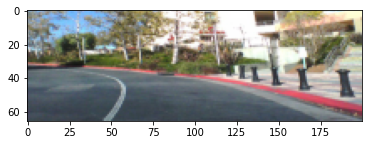



--> Steering Angle Corresponding to above image (In Radians):: [-1.7325873]


In [ ]:
k=500
plt.imshow(x_train[k])
plt.show()
print("\n")
print("--> Steering Angle Corresponding to above image (In Radians)::",y_train[k])

## **DISTRIBUTION OF STEERING ANGLES IN THE TRAINING DATASET VS CV DATASET**

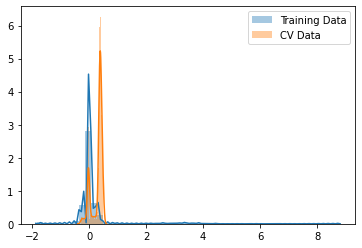

In [ ]:
sb.distplot(y_train,label="Training Data")
sb.distplot(y_cv,label="CV Data")
plt.legend()
plt.show()

## **APPLYING FEW BASE-LINE MODELS**

#### **MEAN SQUARED ERROR IF EVERY PREDICTED ANGLE IS ZERO**

In [ ]:
preds = []
for i in range(500):
  preds.append(0)
print("Mean Squared Loss if every predicted angle is zero::",mean_squared_error(y_cv,preds))

Mean Squared Loss if every predicted angle is zero:: 0.12294541842781558


#### **MEAN SQUARED ERROR ON CV DATA IF EVERY PREDICTED ANGLE IS MEAN OF STEERING ANGLES OF TRAINING DATA**

In [ ]:
train_mean = np.mean(y_train)
print("Mean of Steering Angles of Training Data::",train_mean)
preds = []
for i in range(500):
  preds.append(train_mean)
print("Mean Squared Loss if every predicted angle is mean of steering angles in training data::",mean_squared_error(y_cv,preds))

Mean of Steering Angles of Training Data:: 0.1497140158730159
Mean Squared Loss if every predicted angle is mean of steering angles in training data:: 0.05726586778225875


#### **Thus, The Deep Learning Model we gonna implement should have MSE less than 0.05726586778225875** 

## **THE CNN ARCHITECTURE**

#### **CODE TO SAVE MODEL AFTER EVERY EPOCH**

In [ ]:
#ref:https://stackoverflow.com/questions/54323960/save-keras-model-at-specific-epochs
class CustomSaver(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/saved_models/model_{}.hd5".format(epoch))

#### **THE ARCHITECTURE**

In [ ]:
saver = CustomSaver()
model = Sequential()
model.add(Conv2D(64, (3, 3),activation="relu",strides=2,kernel_initializer='he_normal',input_shape=(66,200,3)))
model.add(Conv2D(64, (3, 3),activation="relu",kernel_initializer='he_normal',strides=2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation=tf.atan))
model.compile(loss = keras.losses.mean_squared_error,optimizer = keras.optimizers.Adam(lr=0.01))
model.fit(x_train,y_train,batch_size=10,epochs=10,validation_data=(x_cv,y_cv),callbacks=[saver]) 

Train on 9000 samples, validate on 500 samples
Epoch 1/10
9000/9000 [==============================] - 90s 10ms/step - loss: 2.1554 - val_loss: 0.0544
Epoch 2/10
9000/9000 [==============================] - 90s 10ms/step - loss: 0.6453 - val_loss: 0.0642
Epoch 3/10
9000/9000 [==============================] - 91s 10ms/step - loss: 0.6436 - val_loss: 0.0732
Epoch 4/10
9000/9000 [==============================] - 90s 10ms/step - loss: 0.6446 - val_loss: 0.0466
Epoch 5/10
9000/9000 [==============================] - 91s 10ms/step - loss: 0.6445 - val_loss: 0.0589
Epoch 6/10
9000/9000 [==============================] - 90s 10ms/step - loss: 0.6444 - val_loss: 0.0776
Epoch 7/10
9000/9000 [==============================] - 91s 10ms/step - loss: 0.6444 - val_loss: 0.0535
Epoch 8/10
9000/9000 [==============================] - 91s 10ms/step - loss: 0.6441 - val_loss: 0.0852
Epoch 9/10
9000/9000 [==============================] - 92s 10ms/step - loss: 0.6444 - val_loss: 0.0597
Epoch 10/10
9000/

### **Using the CNN Architecture we could achieve MSE loss less than the mean random model (which always outputs mean of steering angles in training data for any given image) and significantly less loss compared to zero random model(which always outputs Zero steering angle for any given image) at epoch-4  on Validation-data. So, we can infer that our CNN architecture is training well enough to give decent predictions of steering angles. The best model is saved.**

## **THE DENSE ARCHITECTURE WITH TRANSFER LEARNING (WITH PRE-TRAINED RESNET-50)**

In [ ]:
#ref:https://stackoverflow.com/questions/54323960/save-keras-model-at-specific-epochs
class CustomSaver_tl(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save("/content/drive/My Drive/My Summer Projects/Self_Driving_Car/saved_models/model_TL_{}.hd5".format(epoch))

In [ ]:
saver_tl = CustomSaver_tl()
resnet_50 = ResNet50(include_top=False, weights='imagenet',input_shape=(66,200,3))
model_resnet50=Sequential()
model_resnet50.add(resnet_50)
top_model=Sequential()
top_model.add(Flatten(input_shape=(3,7,2048)))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(32, activation='relu'))
top_model.add(Dense(1, activation=tf.atan))
model_resnet50.add(top_model)
for layer in model_resnet50.layers[0].layers[:174]:
    layer.trainable=False
model_resnet50.compile(loss = keras.losses.mean_squared_error,optimizer = keras.optimizers.Adam(lr=0.001))
values_resnet50=model_resnet50.fit(x_train,y_train,batch_size=100,epochs=10,validation_data=(x_cv,y_cv),callbacks=[saver_tl])

Train on 9000 samples, validate on 500 samples
Epoch 1/10
9000/9000 [==============================] - 587s 65ms/step - loss: 0.5406 - val_loss: 0.0385
Epoch 2/10
9000/9000 [==============================] - 584s 65ms/step - loss: 0.2628 - val_loss: 1.4290
Epoch 3/10
9000/9000 [==============================] - 583s 65ms/step - loss: 0.2445 - val_loss: 2.4729
Epoch 4/10
9000/9000 [==============================] - 581s 65ms/step - loss: 0.2342 - val_loss: 0.0958
Epoch 5/10
9000/9000 [==============================] - 582s 65ms/step - loss: 0.2312 - val_loss: 0.0963
Epoch 6/10
9000/9000 [==============================] - 583s 65ms/step - loss: 0.2275 - val_loss: 1.7125
Epoch 7/10
9000/9000 [==============================] - 583s 65ms/step - loss: 0.2255 - val_loss: 0.4277
Epoch 8/10
9000/9000 [==============================] - 583s 65ms/step - loss: 0.2251 - val_loss: 0.3334
Epoch 9/10
9000/9000 [==============================] - 582s 65ms/step - loss: 0.2252 - val_loss: 0.1972
Epoch 10

### **Using the technique of Transfer Learning we could further reduce the MSE loss to 0.0385 (obtained at epoch-1 and model is saved) from 0.0466 which was obtained by just using CNN architecture.**

## **FINAL TEST LOSS RESULTS**

#### **TEST LOSS FOR A MEAN RANDOM MODEL**

In [ ]:
train_mean = np.mean(y_train)
preds_mean = []
for i in range(len(x_test)):
  preds_mean.append(train_mean)
print("Test loss when every predicted angle is mean of training data angles::",mean_squared_error(y_test,preds_mean))

Test loss when every predicted angle is mean of training data angles:: 0.08559424278480952


#### **TEST LOSS WHEN USED MODEL BUILT USING TRANSFER LEARNING**

In [ ]:
pred_TL = model_resnet50.predict(x_test)
print("Test loss using the model built using Transfer-Learning::",mean_squared_error(y_test,pred_TL))

Test loss using the model built using Transfer-Learning:: 0.05893282481686549


## **REFERENCES**
1. Bojarski, M., Del Testa, D., Dworakowski, D., Firner, B., Flepp, B., Goyal, P., ... & Zhang, X. (2016). End to end learning for self-driving cars. arXiv preprint arXiv:1604.07316.

2. Data-set Source: https://github.com/SullyChen/driving-datasets